# Fully convolutional Networks for Semantic Segmentation
https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf

In [0]:
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision
from torchvision import models
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
from PIL import Image
from collections import Counter




## Dataset : Pascal VOC 2007

In [64]:
# delete folder if exists
!rm -rf /tmp/voc2007
print('rm done.')

rm done.


In [65]:
dataroot = '/tmp/voc2007'
dset.VOCSegmentation(dataroot,year='2007', image_set='train', download=True)


Dataset VOCSegmentation
    Number of datapoints: 209
    Root location: /tmp/voc2007

tensor([7.0276e-01, 1.6168e-01, 5.0462e-02, 1.1129e-02, 1.2878e-02, 5.9402e-03,
        3.4075e-03, 2.2567e-03, 4.1291e-04, 6.9558e-04, 4.2844e-04, 7.3918e-06,
        6.1754e-06, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.7943e-02])


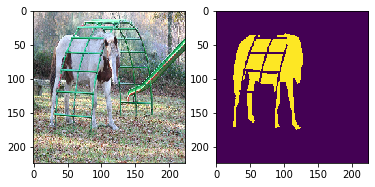

In [66]:
"""Pascal VOC Dataset Segmentation Dataloader"""


VOC_CLASSES = ('background',  # always index 0
               'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor')

NUM_CLASSES = len(VOC_CLASSES) + 1


class PascalVOCDataset(Dataset):
    """Pascal VOC 2007 Dataset"""
    def __init__(self, list_file, img_dir, mask_dir, transform=None):
        self.images = open(list_file, "rt").read().split("\n")[:-1]
        self.transform = transform

        self.img_extension = ".jpg"
        self.mask_extension = ".png"

        self.image_root_dir = img_dir
        self.mask_root_dir = mask_dir

        self.counts = self.__compute_class_probability()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        name = self.images[index]
        image_path = os.path.join(self.image_root_dir, name + self.img_extension)
        mask_path = os.path.join(self.mask_root_dir, name + self.mask_extension)

        image = self.load_image(path=image_path)
        gt_mask = self.load_mask(path=mask_path)

        data = (torch.FloatTensor(image), torch.LongTensor(gt_mask))

        return data

    def __compute_class_probability(self):
        counts = dict((i, 0) for i in range(NUM_CLASSES))

        for name in self.images:
            mask_path = os.path.join(self.mask_root_dir, name + self.mask_extension)

            raw_image = Image.open(mask_path).resize((224, 224))
            imx_t = np.array(raw_image).reshape(224*224)
            imx_t[imx_t==255] = 21

            for i in range(NUM_CLASSES):
                counts[i] += np.sum(imx_t == i)

        return counts

    def get_class_probability(self):
        values = np.array(list(self.counts.values()))
        p_values = values/np.sum(values)

        return torch.Tensor(p_values)

    def load_image(self, path=None):
        raw_image = Image.open(path)
        raw_image = np.transpose(raw_image.resize((224, 224)), (2,1,0))
        imx_t = np.array(raw_image, dtype=np.float32)/255.0

        return imx_t

    def load_mask(self, path=None):
        raw_image = Image.open(path)
        raw_image = raw_image.resize((224, 224))
        imx_t = np.array(raw_image)
        # border
        imx_t[imx_t==255] = 0

        return imx_t


data_root = "/tmp/voc2007/VOCdevkit/VOC2007"
list_file_path = os.path.join(data_root, "ImageSets", "Segmentation", "train.txt")
img_dir = os.path.join(data_root, "JPEGImages")
mask_dir = os.path.join(data_root, "SegmentationObject")

## Train
train_dataset = PascalVOCDataset(list_file=list_file_path,
                                    img_dir=img_dir,
                                    mask_dir=mask_dir)

## train_val 
list_file_path = os.path.join(data_root, "ImageSets", "Segmentation", "trainval.txt")

trainval_dataset = PascalVOCDataset(list_file=list_file_path,
                                    img_dir=img_dir,
                                    mask_dir=mask_dir)
## val
list_file_path = os.path.join(data_root, "ImageSets", "Segmentation", "val.txt")

val_dataset = PascalVOCDataset(list_file=list_file_path,
                                    img_dir=img_dir,
                                    mask_dir=mask_dir)

print(val_dataset.get_class_probability())

sample = val_dataset[7]
image, mask = sample[0], sample[1]

image.transpose_(0, 2)

fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(image)

a = fig.add_subplot(1,2,2)
plt.imshow(mask)

plt.show()

device : cuda:0


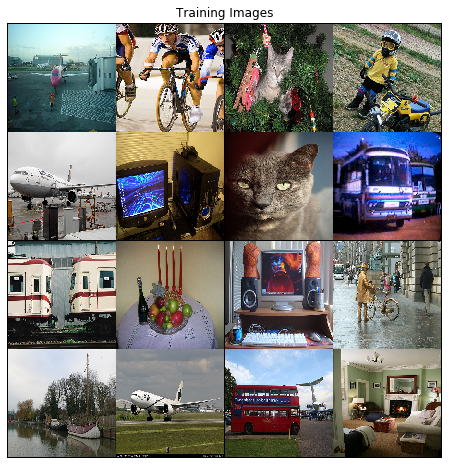

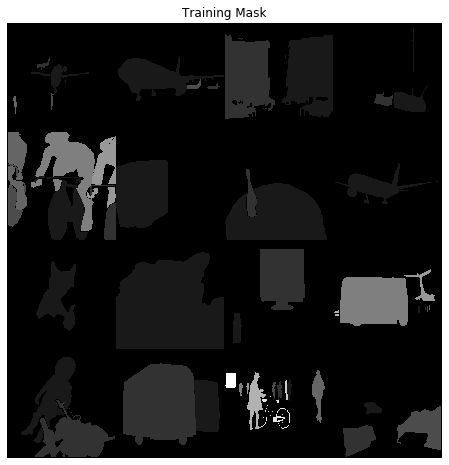

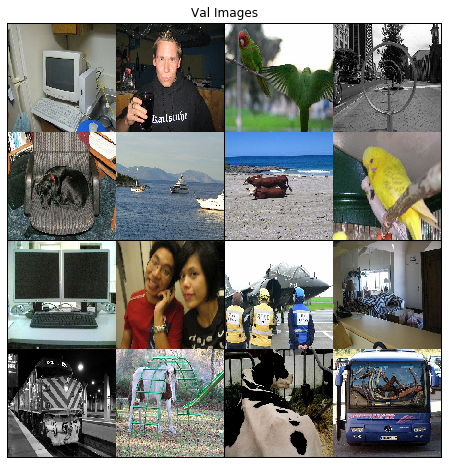

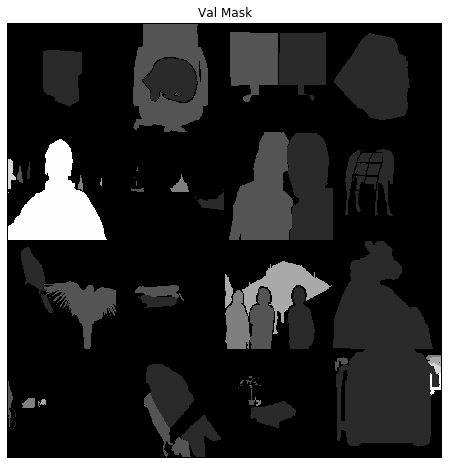

In [67]:

# Set batch_size
batch_size = 20

dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
dataloader_train_val = torch.utils.data.DataLoader(trainval_dataset, batch_size=batch_size)
dataloader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device :",device)

# Plot some training images
real_batch = next(iter(dataloader_train))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].float()[:16], padding=2, normalize=True,nrow=4).cpu()))
plt.show()

rb=torch.stack([real_batch[1],real_batch[1],real_batch[1]],dim=1)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Mask")
plt.imshow(np.transpose(vutils.make_grid(rb.float()[:16], padding=2, normalize=True,nrow=4).cpu(),(1,2,0)))
plt.show()

# Plot some val images
real_batch = next(iter(dataloader_val))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Val Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:16], padding=2, normalize=True,nrow=4).cpu()))
plt.show()
rb=torch.stack([real_batch[1],real_batch[1],real_batch[1]],dim=1)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Val Mask")
plt.imshow(np.transpose(vutils.make_grid(rb.float().to(device)[:16], padding=2, normalize=True,nrow=4).cpu(),(1,2,0)))
plt.show()

In [68]:
print("Taille dataset train :",len(train_dataset))
print("Taille dataset trainval :",len(trainval_dataset))
print("Taille dataset val :",len(val_dataset))

Taille dataset train : 209
Taille dataset trainval : 422
Taille dataset val : 213


## Metric code

In [69]:
SMOOTH = 1e-6
def iou(outputs: torch.Tensor, labels: torch.Tensor):

    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    #thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return iou.mean()  # Or thresholded.mean() if you are interested in average across the batch
    


 
iou(next(iter(dataloader_train))[1],next(iter(dataloader_train_val))[1])

tensor(0.1427)

## FCN for Semantic Segmentation models

In [70]:
print('Instanciation de VGG16')
vgg16 = models.vgg16(pretrained=True)
vgg16

Instanciation de VGG16


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
#vgg16.classifier[3].weight.unsqueeze(2).unsqueeze(3).size()

In [0]:
class FCN32_VGG16(torch.nn.Module): # Archi FCN-32s du papier
    def __init__(self,vgg16):
        super(FCN32_VGG16,self).__init__()
        self.features_im_net = nn.Sequential(*list(vgg16.features.children()))
        # On ne considère que les features et on supprime les couches fully connected.
        # pour les remplacer par des conv 
        # on ne garde pas l'avg pool
        # [512,7,7]
        
        self.conv1 = nn.Conv2d(512,4096,kernel_size=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout()
        self.conv2 = nn.Conv2d(4096,4096,kernel_size=(1,1))
        self.conv2.weight = nn.Parameter(vgg16.classifier[3].weight.unsqueeze(2).unsqueeze(3))
        self.conv2.bias = vgg16.classifier[3].bias
        self.conv3 = nn.Conv2d(4096,21,kernel_size=(1,1))

        """
        self.conv_classif = nn.Sequential(
            
            nn.Conv2d(512,4096,kernel_size=(1,1)), #mettre poids w des lineaires vgg
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Conv2d(4096,4096,kernel_size=(1,1)),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Conv2d(4096,21,kernel_size=(1,1))
        )"""
        # [21,1,1]
        self.upsampling = nn.Sequential(
            #nn.ConvTranspose2d(21,1,kernel_size=(7,7)), # Pas sur mais pour augmenter d'un facteur 32 pour arriver à 224
            #, il nous faut des fmaps de taille 7 #Pas sur pour dim_out =1 non plus.
            nn.UpsamplingBilinear2d(scale_factor=32)#,
            #nn.Sigmoid()

        )
        


    def forward(self,x):
        x = self.features_im_net(x)
        # Si on veut utiliser les poids du linéaire de vgg
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv3(x)
        # Si on veut ne pas utiliser les poids du linéaire vgg
        #x = self.conv_classif(x)
        x = self.upsampling(x)  

        return x # [224,224]

In [73]:
fcn32 = FCN32_VGG16(vgg16)
fcn32.to(device)

FCN32_VGG16(
  (features_im_net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, paddin

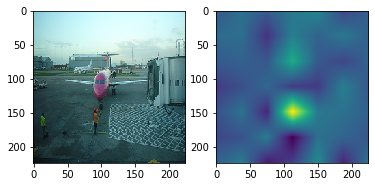

In [74]:
batch_test = next(iter(dataloader_train))[0]
output_f = fcn32(batch_test.to(device))




fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(np.transpose(batch_test[0].cpu()))

a = fig.add_subplot(1,2,2)
plt.imshow(output_f[0][0].cpu().detach().numpy())

plt.show()

## Training

In [0]:
learning_rate = 10e-4
moment = 0.9
optimizer = torch.optim.Adam(fcn32.parameters(),lr=learning_rate)
n_epochs = 80
#writer = SummaryWriter()
criterion = nn.CrossEntropyLoss(ignore_index=21) # On ignore la classe border.

EPOCH 0


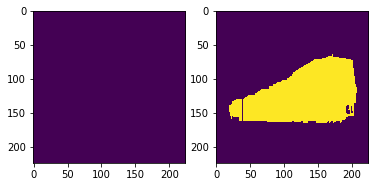

EPOCH 1
EPOCH 2
EPOCH 3
EPOCH 4
EPOCH 5
EPOCH 6
EPOCH 7
EPOCH 8
EPOCH 9
EPOCH 10
EPOCH 11
EPOCH 12
EPOCH 13
EPOCH 14
EPOCH 15
EPOCH 16
EPOCH 17
EPOCH 18
EPOCH 19
EPOCH 20


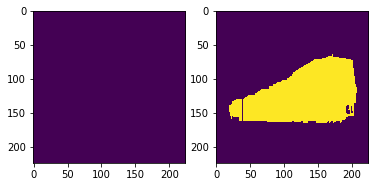

EPOCH 21
EPOCH 22
EPOCH 23
EPOCH 24
EPOCH 25
EPOCH 26
EPOCH 27
EPOCH 28
EPOCH 29
EPOCH 30
EPOCH 31
EPOCH 32
EPOCH 33
EPOCH 34
EPOCH 35
EPOCH 36
EPOCH 37
EPOCH 38
EPOCH 39
EPOCH 40


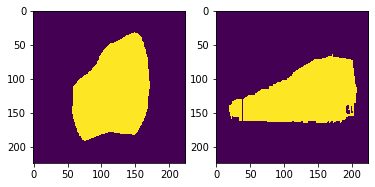

EPOCH 41
EPOCH 42
EPOCH 43
EPOCH 44
EPOCH 45
EPOCH 46
EPOCH 47
EPOCH 48
EPOCH 49
EPOCH 50
EPOCH 51
EPOCH 52
EPOCH 53
EPOCH 54
EPOCH 55
EPOCH 56
EPOCH 57
EPOCH 58
EPOCH 59
EPOCH 60


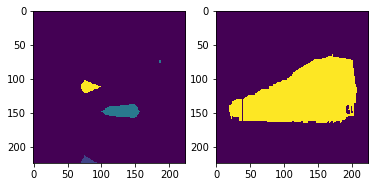

EPOCH 61
EPOCH 62
EPOCH 63
EPOCH 64
EPOCH 65
EPOCH 66
EPOCH 67
EPOCH 68
EPOCH 69
EPOCH 70
EPOCH 71
EPOCH 72
EPOCH 73
EPOCH 74
EPOCH 75
EPOCH 76
EPOCH 77
EPOCH 78
EPOCH 79


In [76]:
SAVE_DIR = '/tmp/model'
iou_train = []
loss_train = []
iou_test = []
loss_test = []
for ep in range(n_epochs):
    print("EPOCH",ep)

    for i,(x,mask) in enumerate(dataloader_train):
        if i!=5:
            x = x.to(device)
            mask = mask.to(device)

            fcn32.train()
            pred = fcn32(x)
            pred = pred.squeeze()

            #print('i =',i)

            loss = criterion(pred,mask)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    loss_train.append(loss.item()) #.item() pour eviter fuite memoire
    iou_train.append(iou(pred.max(dim=1)[1],mask))
    for i,(x,mask) in enumerate(dataloader_val):
        if i!=5 or i ==5:
            x = x.to(device)
            mask = mask.to(device)

            fcn32.eval()
            pred = fcn32(x)
            pred = pred.squeeze()

            loss = criterion(pred,mask)
    loss_test.append(loss.item())
    iou_test.append(iou(pred.max(dim=1)[1],mask))

    if ep%20==0:
      try:
        fig = plt.figure()

        a = fig.add_subplot(1,2,1)
        plt.imshow(np.transpose(pred.max(dim=1)[1][0].cpu()))

        a = fig.add_subplot(1,2,2)
        plt.imshow(mask.cpu().detach().numpy()[0])

        plt.show()
      except:
        print('something wrong plot images')
    

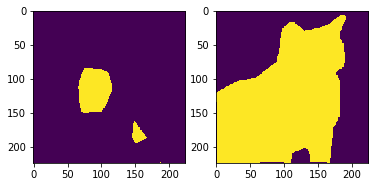

In [77]:
fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(np.transpose(pred.max(dim=1)[1][7].cpu()))

a = fig.add_subplot(1,2,2)
plt.imshow(mask.cpu().detach().numpy()[7])

plt.show()

## Plot

Text(0, 0.5, 'Mean IOU')

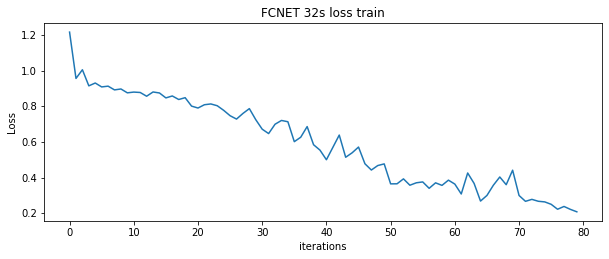

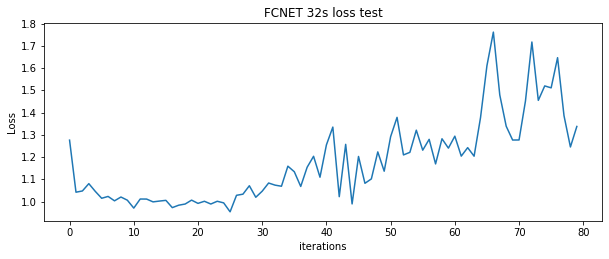

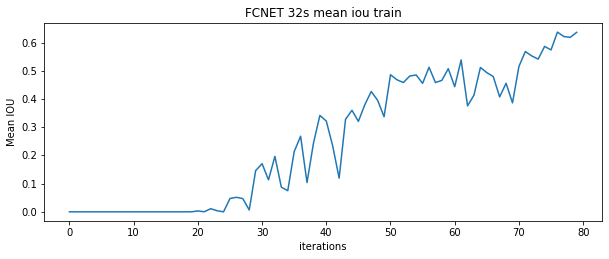

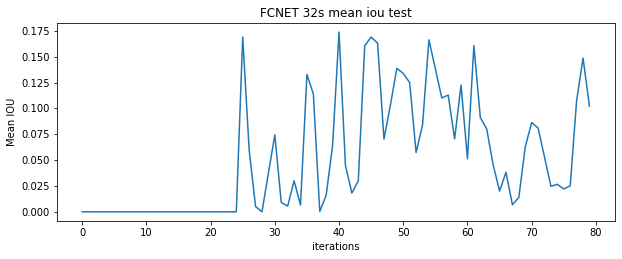

In [78]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 32s loss train")
plt.plot(loss_train)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 32s loss test")
plt.plot(loss_test)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 32s mean iou train")
plt.plot(iou_train)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 32s mean iou test")
plt.plot(iou_test)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")

In [79]:
iou_train[79]

tensor(0.6363, device='cuda:0')

In [80]:
iou_test[79]

tensor(0.1022, device='cuda:0')

### Implémentation de la variante FCN-16s 

In [81]:
fcn32

FCN32_VGG16(
  (features_im_net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, paddin

In [82]:
list(fcn32.features_im_net.children())[:24]

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1

In [0]:
class FCN16_VGG16(torch.nn.Module): # Archi FCN-16s du papier
    def __init__(self,fcn32):
        super(FCN16_VGG16,self).__init__()
        
        self.features_pool4 = nn.Sequential(*list(fcn32.features_im_net.children())[:24]) # Features coupé à la couche pool4
        self.features_fc32 = nn.Sequential(*list(fcn32.features_im_net.children())[24:]) # Features complet de fc32
        # Classifieur FCN32
        self.conv1 = nn.Conv2d(512,4096,kernel_size=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout()
        self.conv2 = nn.Conv2d(4096,4096,kernel_size=(1,1))
        self.conv2.weight = nn.Parameter(vgg16.classifier[3].weight.unsqueeze(2).unsqueeze(3))
        self.conv2.bias = vgg16.classifier[3].bias
        self.conv3 = nn.Conv2d(4096,21,kernel_size=(1,1))

        # Classifieur branche FCN16

        self.conv_fc16 = nn.Conv2d(512,21,kernel_size=(1,1)) # [14,14]
        

        # Upsampling
        self.final_upsampling = nn.UpsamplingBilinear2d(scale_factor=16)
        self.combine_classif_upsampling = nn.UpsamplingBilinear2d(scale_factor=2)
        


    def forward(self,x):
        x = self.features_pool4(x)
        # branche fc32
        x1 = self.features_fc32(x)
        x1 = self.conv1(x1)
        x1 = self.relu(x1)
        x1 = self.dropout(x1)
        x1 = self.conv2(x1)
        x1 = self.relu(x1)
        x1 = self.dropout(x1)
        x1 = self.conv3(x1) # [7,7]
        x1 = self.combine_classif_upsampling(x1) # [14,14]
        
        # branche fc16
        x2 = self.conv_fc16(x)

        # Somme des classifieurs
        x = x1+x2 
        mask = self.final_upsampling(x)  

        return mask # [224,224]

In [84]:
fcn16 = FCN16_VGG16(fcn32) # Comme l'article on réentraine sur fc32
fcn16.to(device)

FCN16_VGG16(
  (features_pool4): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding

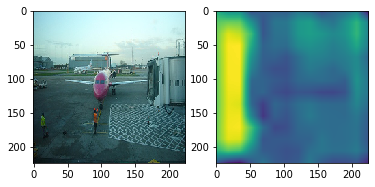

In [85]:
batch_test = next(iter(dataloader_train))[0]
output_f = fcn16(batch_test.to(device))




fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(np.transpose(batch_test[0].cpu()))

a = fig.add_subplot(1,2,2)
plt.imshow(output_f[0][0].cpu().detach().numpy())

plt.show()

In [0]:
learning_rate = 10e-4
moment = 0.9
optimizer = torch.optim.Adam(fcn16.parameters(),lr=learning_rate)
n_epochs = 80
#writer = SummaryWriter()
criterion = nn.CrossEntropyLoss(ignore_index=21) # On ignore la classe border.

EPOCH 0


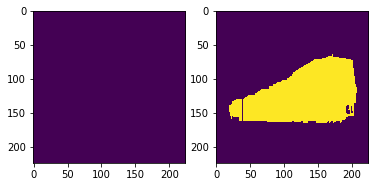

EPOCH 1
EPOCH 2
EPOCH 3
EPOCH 4
EPOCH 5
EPOCH 6
EPOCH 7
EPOCH 8
EPOCH 9
EPOCH 10
EPOCH 11
EPOCH 12
EPOCH 13
EPOCH 14
EPOCH 15
EPOCH 16
EPOCH 17
EPOCH 18
EPOCH 19
EPOCH 20


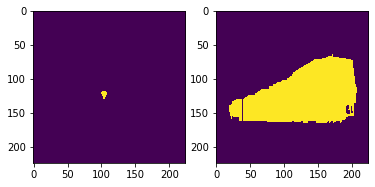

EPOCH 21
EPOCH 22
EPOCH 23
EPOCH 24
EPOCH 25
EPOCH 26
EPOCH 27
EPOCH 28
EPOCH 29
EPOCH 30
EPOCH 31
EPOCH 32
EPOCH 33
EPOCH 34
EPOCH 35
EPOCH 36
EPOCH 37
EPOCH 38
EPOCH 39
EPOCH 40


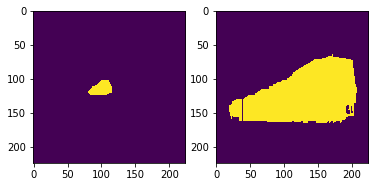

EPOCH 41
EPOCH 42
EPOCH 43
EPOCH 44
EPOCH 45
EPOCH 46
EPOCH 47
EPOCH 48
EPOCH 49
EPOCH 50
EPOCH 51
EPOCH 52
EPOCH 53
EPOCH 54
EPOCH 55
EPOCH 56
EPOCH 57
EPOCH 58
EPOCH 59
EPOCH 60


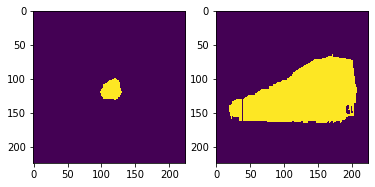

EPOCH 61
EPOCH 62
EPOCH 63
EPOCH 64
EPOCH 65
EPOCH 66
EPOCH 67
EPOCH 68
EPOCH 69
EPOCH 70
EPOCH 71
EPOCH 72
EPOCH 73
EPOCH 74
EPOCH 75
EPOCH 76
EPOCH 77
EPOCH 78
EPOCH 79


In [87]:
SAVE_DIR = '/tmp/model'
iou_train = []
loss_train = []
iou_test = []
loss_test = []
for ep in range(n_epochs):
    print("EPOCH",ep)

    for i,(x,mask) in enumerate(dataloader_train):
        if i!=5:
            x = x.to(device)
            mask = mask.to(device)

            fcn16.train()
            pred = fcn16(x)
            pred = pred.squeeze()

            #print('i =',i)

            loss = criterion(pred,mask)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    loss_train.append(loss.item()) #.item() pour eviter fuite memoire
    iou_train.append(iou(pred.max(dim=1)[1],mask))
    for i,(x,mask) in enumerate(dataloader_val):
        if i!=5 or i ==5:
            x = x.to(device)
            mask = mask.to(device)

            fcn16.eval()
            pred = fcn16(x)
            pred = pred.squeeze()

            loss = criterion(pred,mask)
    loss_test.append(loss.item())
    iou_test.append(iou(pred.max(dim=1)[1],mask))

    if ep%20==0:
      try:
        fig = plt.figure()

        a = fig.add_subplot(1,2,1)
        plt.imshow(np.transpose(pred.max(dim=1)[1][0].cpu()))

        a = fig.add_subplot(1,2,2)
        plt.imshow(mask.cpu().detach().numpy()[0])

        plt.show()
      except:
        print('something wrong plot images')
    

Text(0, 0.5, 'Mean IOU')

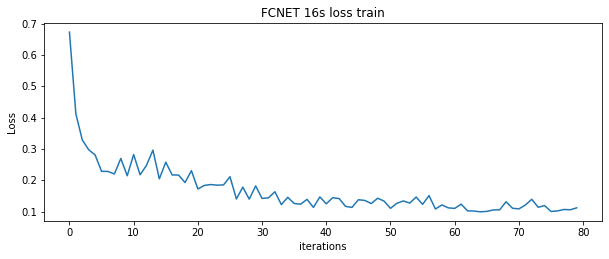

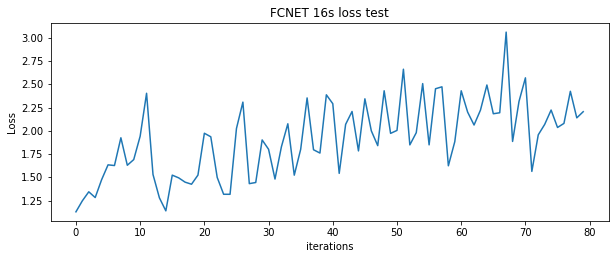

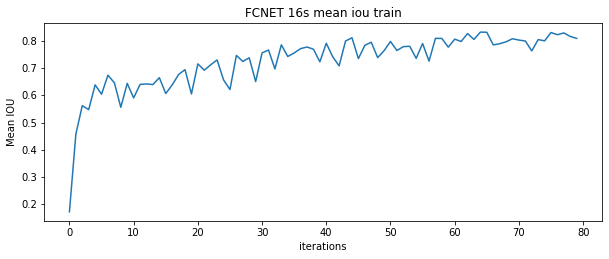

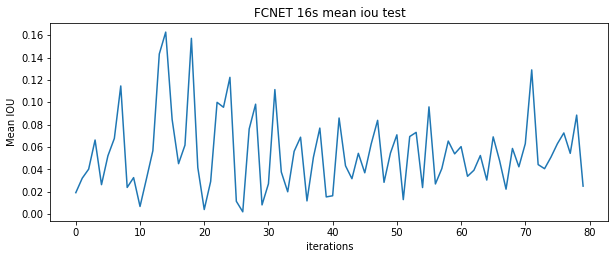

In [88]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 16s loss train")
plt.plot(loss_train)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 16s loss test")
plt.plot(loss_test)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 16s mean iou train")
plt.plot(iou_train)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 16s mean iou test")
plt.plot(iou_test)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")

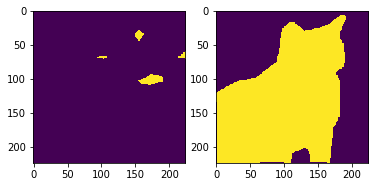

In [89]:
fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(np.transpose(pred.max(dim=1)[1][7].cpu()))

a = fig.add_subplot(1,2,2)
plt.imshow(mask.cpu().detach().numpy()[7])

plt.show()

In [90]:
mask.cpu().detach().numpy()[7].max()

1

In [91]:
pred.max(dim=1)[1][7].cpu().max()

tensor(2)

In [92]:
list(fcn16.features_pool4)[:17]

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)]

### Implémentation de la variante FCN-8s

In [0]:
class FCN8_VGG16(torch.nn.Module): # Archi FCN-16s du papier
    def __init__(self,fcn16):
        super(FCN8_VGG16,self).__init__()
        self.features_pool3 = nn.Sequential(*list(fcn16.features_pool4.children())[:17]) # Features coupé à la couche pool3
        self.features_pool4 = nn.Sequential(*list(fcn16.features_pool4.children())[17:24]) # Features coupé à la couche pool4
        self.features_fc32 = nn.Sequential(*list(fcn16.features_fc32.children())) # Features complet de fc32
        # Classifieur FCN32
        self.conv1 = nn.Conv2d(512,4096,kernel_size=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout()
        self.conv2 = nn.Conv2d(4096,4096,kernel_size=(1,1))
        self.conv3 = nn.Conv2d(4096,21,kernel_size=(1,1))

        # Copy weight from classifier
        self.conv1.weight = nn.Parameter(fcn16.conv1.weight)
        self.conv1.bias = fcn16.conv1.bias
        self.conv2.weight = nn.Parameter(fcn16.conv2.weight)
        self.conv2.bias = fcn16.conv2.bias
        self.conv3.weight = nn.Parameter(fcn16.conv3.weight)
        self.conv3.bias = fcn16.conv3.bias

        # Classifieur branche FCN16

        self.conv_fc16 = nn.Conv2d(512,21,kernel_size=(1,1)) # [14,14]

        # Classifieur branche FCN8

        self.conv_fc8 = nn.Conv2d(256,21,kernel_size=(1,1)) # [28,28]
        

        # Upsampling
        self.final_upsampling = nn.UpsamplingBilinear2d(scale_factor=8)
        self.combine_classif_upsampling = nn.UpsamplingBilinear2d(scale_factor=2)
        


    def forward(self,x):
        x0 = self.features_pool3(x)
        # branche fc32 et fc16
        x1 = self.features_pool4(x0)

        # branche fc32
        x2 = self.features_fc32(x1)
        x2 = self.conv1(x2)
        x2 = self.relu(x2)
        x2 = self.dropout(x2)
        x2 = self.conv2(x2)
        x2 = self.relu(x2)
        x2 = self.dropout(x2)
        x2 = self.conv3(x2) # [7,7]
        x2 = self.combine_classif_upsampling(x2) # [14,14]
        
        # branche fc16
        x3 = self.conv_fc16(x1) # [14,14]

        # branche fc8
        x4 = self.conv_fc8(x0) # [28,28]

        # Somme des classifieurs fc16 et fc32
        x5 = x2+x3 # [14,14]
        x5 = self.combine_classif_upsampling(x5) # [28,28]

        # somme des classifieurs fc8 et fc16+32
        x6 = x5 + x4

        mask = self.final_upsampling(x6)  

        return mask # [224,224]

In [99]:
fcn8 = FCN8_VGG16(fcn16) # Comme l'article on réentraine sur fc16
fcn8.to(device)

FCN8_VGG16(
  (features_pool3): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=

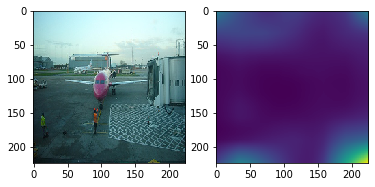

In [100]:
batch_test = next(iter(dataloader_train))[0]
output_f = fcn8(batch_test.to(device))




fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(np.transpose(batch_test[0].cpu()))

a = fig.add_subplot(1,2,2)
plt.imshow(output_f[0][0].cpu().detach().numpy())

plt.show()

In [0]:
learning_rate = 10e-4
moment = 0.9
optimizer = torch.optim.Adam(fcn8.parameters(),lr=learning_rate)
n_epochs = 80
#writer = SummaryWriter()
criterion = nn.CrossEntropyLoss(ignore_index=21) # On ignore la classe border.

EPOCH 0


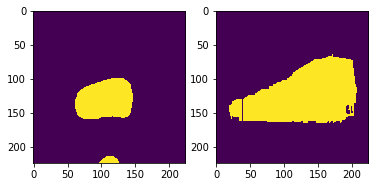

EPOCH 1
EPOCH 2
EPOCH 3
EPOCH 4
EPOCH 5
EPOCH 6
EPOCH 7
EPOCH 8
EPOCH 9
EPOCH 10
EPOCH 11
EPOCH 12
EPOCH 13
EPOCH 14
EPOCH 15
EPOCH 16
EPOCH 17
EPOCH 18
EPOCH 19
EPOCH 20


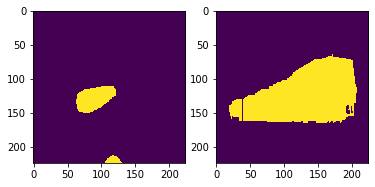

EPOCH 21
EPOCH 22
EPOCH 23
EPOCH 24
EPOCH 25
EPOCH 26
EPOCH 27
EPOCH 28
EPOCH 29
EPOCH 30
EPOCH 31
EPOCH 32
EPOCH 33
EPOCH 34
EPOCH 35
EPOCH 36
EPOCH 37
EPOCH 38
EPOCH 39
EPOCH 40


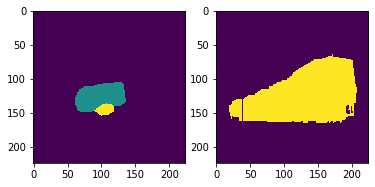

EPOCH 41
EPOCH 42
EPOCH 43
EPOCH 44
EPOCH 45
EPOCH 46
EPOCH 47
EPOCH 48
EPOCH 49
EPOCH 50
EPOCH 51
EPOCH 52
EPOCH 53
EPOCH 54
EPOCH 55
EPOCH 56
EPOCH 57
EPOCH 58
EPOCH 59
EPOCH 60


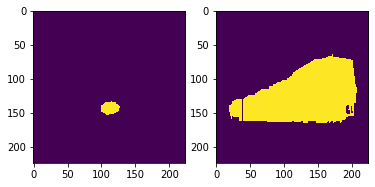

EPOCH 61
EPOCH 62
EPOCH 63
EPOCH 64
EPOCH 65
EPOCH 66
EPOCH 67
EPOCH 68
EPOCH 69
EPOCH 70
EPOCH 71
EPOCH 72
EPOCH 73
EPOCH 74
EPOCH 75
EPOCH 76
EPOCH 77
EPOCH 78
EPOCH 79


In [102]:
SAVE_DIR = '/tmp/model'
iou_train = []
loss_train = []
iou_test = []
loss_test = []
for ep in range(n_epochs):
    print("EPOCH",ep)

    for i,(x,mask) in enumerate(dataloader_train):
        if i!=5:
            x = x.to(device)
            mask = mask.to(device)

            fcn8.train()
            pred = fcn8(x)
            pred = pred.squeeze()

            #print('i =',i)

            loss = criterion(pred,mask)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    loss_train.append(loss.item()) #.item() pour eviter fuite memoire
    iou_train.append(iou(pred.max(dim=1)[1],mask))
    for i,(x,mask) in enumerate(dataloader_val):
        if i!=5 or i ==5:
            x = x.to(device)
            mask = mask.to(device)

            fcn8.eval()
            pred = fcn8(x)
            pred = pred.squeeze()

            loss = criterion(pred,mask)
    loss_test.append(loss.item())
    iou_test.append(iou(pred.max(dim=1)[1],mask))

    if ep%20==0:
      try:
        fig = plt.figure()

        a = fig.add_subplot(1,2,1)
        plt.imshow(np.transpose(pred.max(dim=1)[1][0].cpu()))

        a = fig.add_subplot(1,2,2)
        plt.imshow(mask.cpu().detach().numpy()[0])

        plt.show()
      except:
        print('something wrong plot images')
    

Text(0, 0.5, 'Mean IOU')

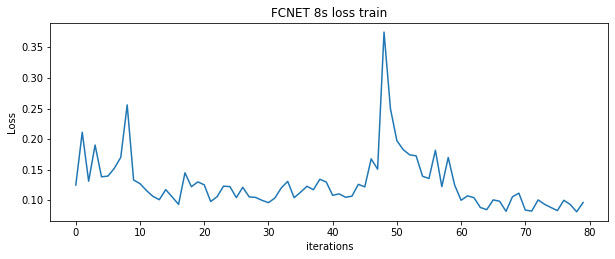

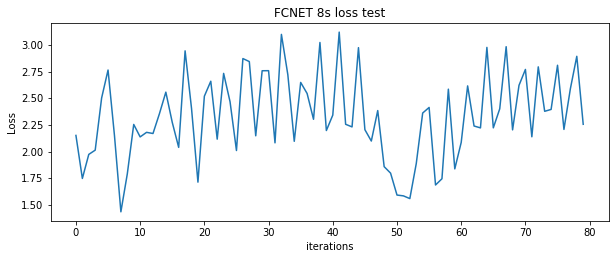

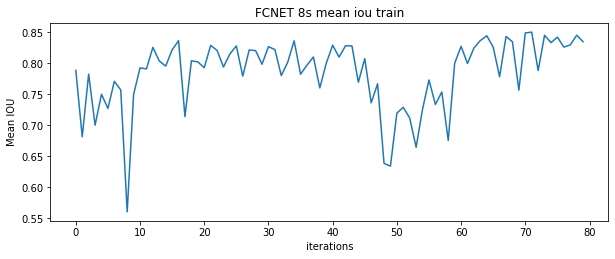

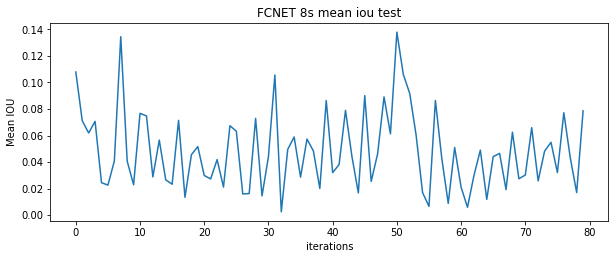

In [103]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 8s loss train")
plt.plot(loss_train)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 8s loss test")
plt.plot(loss_test)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 8s mean iou train")
plt.plot(iou_train)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 8s mean iou test")
plt.plot(iou_test)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")